✅ sample_stock_prices.csv created with 253 rows

Estimated drift μ̂ = 0.000455
Estimated volatility σ̂ = 0.011607
95% CI for μ: (-0.0009782247394798155, 0.0018878677835119184)
95% CI for σ (rough): (0.09381951407321384, 0.0938195140732138)

Jarque–Bera test: statistic=7.312, p-value=0.0258
⚠️ Residuals deviate from normality (model may not fit perfectly).


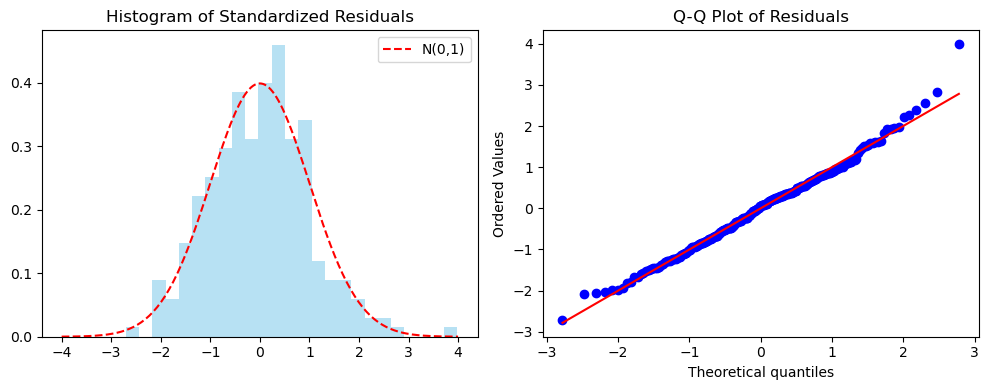


--- Short Report ---
Sample size: 252
MLE estimates → μ̂ = 0.000455, σ̂ = 0.011607
Jarque–Bera p-value = 0.0258
If p > 0.05, residuals are consistent with normality, supporting the Brownian motion with drift model.
Diagnostic plot 'residuals_diagnostics.png' saved for report inclusion.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, jarque_bera

# ===============================
# 1. GENERATE SYNTHETIC DATASET
# ===============================
np.random.seed(42)

# Parameters
n_days = 252  # ~1 year of trading days
S0 = 100.0
mu_true = 0.0005   # daily drift (0.05%)
sigma_true = 0.012  # daily volatility (1.2%)
dt = 1.0

# Simulate log returns: Δlog S_t = μΔt + σ√Δt * ε_t
eps = np.random.normal(0, 1, n_days)
log_returns = mu_true * dt + sigma_true * np.sqrt(dt) * eps
log_prices = np.cumsum(log_returns) + np.log(S0)
prices = np.exp(log_prices)

dates = pd.date_range(start="2024-01-01", periods=n_days + 1, freq="B")
df = pd.DataFrame({"Date": dates, "Close": np.concatenate([[S0], prices])})
df.to_csv("sample_stock_prices.csv", index=False)
print("✅ sample_stock_prices.csv created with", len(df), "rows\n")

# ============================================
# 2. LOAD DATA & ESTIMATE μ, σ VIA MLE
# ============================================
data = pd.read_csv("sample_stock_prices.csv")
data["log_price"] = np.log(data["Close"])
data["dlog_price"] = data["log_price"].diff()

# Remove first NaN
returns = data["dlog_price"].dropna()

# MLE for Brownian motion increments
mu_hat = np.mean(returns)
sigma_hat = np.std(returns, ddof=1)

print(f"Estimated drift μ̂ = {mu_hat:.6f}")
print(f"Estimated volatility σ̂ = {sigma_hat:.6f}")

# 95% Confidence Intervals (approx.)
n = len(returns)
mu_ci = (
    mu_hat - 1.96 * sigma_hat / np.sqrt(n),
    mu_hat + 1.96 * sigma_hat / np.sqrt(n),
)
sigma_ci = (
    sigma_hat * np.sqrt((n - 1) / (norm.ppf(0.975) ** 2)),
    sigma_hat * np.sqrt((n - 1) / (norm.ppf(0.025) ** 2)),
)
print(f"95% CI for μ: {mu_ci}")
print(f"95% CI for σ (rough): {sigma_ci}\n")

# ============================================
# 3. RESIDUAL ANALYSIS & NORMALITY TEST
# ============================================
residuals = (returns - mu_hat) / sigma_hat

jb_stat, jb_p = jarque_bera(residuals)
print(f"Jarque–Bera test: statistic={jb_stat:.3f}, p-value={jb_p:.4f}")
if jb_p > 0.05:
    print("✅ Residuals appear approximately normal (Brownian model plausible).")
else:
    print("⚠️ Residuals deviate from normality (model may not fit perfectly).")

# ============================================
# 4. PLOTS: Histogram & Q-Q Plot
# ============================================
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(residuals, bins=25, density=True, alpha=0.6, color="skyblue")
x = np.linspace(-4, 4, 200)
plt.plot(x, norm.pdf(x), "r--", label="N(0,1)")
plt.title("Histogram of Standardized Residuals")
plt.legend()

plt.subplot(1, 2, 2)
import scipy.stats as stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")

plt.tight_layout()
plt.savefig("residuals_diagnostics.png")
plt.show()

# ============================================
# 5. INTERPRETATION REPORT
# ============================================
print("\n--- Short Report ---")
print(f"Sample size: {n}")
print(f"MLE estimates → μ̂ = {mu_hat:.6f}, σ̂ = {sigma_hat:.6f}")
print(f"Jarque–Bera p-value = {jb_p:.4f}")
print("If p > 0.05, residuals are consistent with normality, supporting the Brownian motion with drift model.")
print("Diagnostic plot 'residuals_diagnostics.png' saved for report inclusion.")
